In [59]:
import json
import numpy as np
import matplotlib
from scipy.interpolate    import interp1d
from scipy                import integrate
import glob
import scipy 
from matplotlib import style
style.use('ggplot')
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import os
os.environ['pandeia_refdata'] = "/home/maryhallow/Desktop/python/Reionizatoin/JWSTUserTraining2016/pandeia_data"
os.environ['PYSYN_CDBS'] = "/home/maryhallow/Desktop/python/Reionizatoin/JWSTUserTraining2016/cdbs.23.1.rc3"

from pandeia.engine.perform_calculation import perform_calculation
from pandeia.engine.calc_utils import build_default_calc

In [60]:
N_sim_1 = 0
N_sim_2 = 1

def read_simulation_data():

    global info, lums, z, nbins, nbins_min, z, indices, angles, theta_min

    info = glob.glob("./output/info_rei000" + str(N_sim_1) + str(N_sim_2) + "_*")
    lums = np.vstack((sorted(glob.glob("./output/lum_150_rei000" + str(N_sim_1) + str(N_sim_2) + "_*")),
                      sorted(glob.glob("./output/lum_200_rei000" + str(N_sim_1) + str(N_sim_2) + "_*"))))

    z      = []
    nbins  = []
    angles = []

    for i in range(0,len(info)):
        N, redshift, D_A, theta = np.loadtxt(info[i], skiprows=1)
        z.append(redshift)
        nbins.append(int(N))
        angles.append(theta)

    z       = np.array(z)
    indices = np.argsort(z)[::-1]
    z       = z[indices]

    nbins     = np.array(nbins)
    angles    = np.array(angles)
    nbins     = nbins[indices]
    angles    = angles[indices]
    nbins_min = np.min(nbins)
    theta_min = np.min(angles)

    print(nbins_min)
    print(theta_min)
    
read_simulation_data()

80
10.4112084856


In [61]:
print('Redshifts:')
print(np.round(z,2))
print()
print('Number of pixels:')
print(nbins)
print()
print('Angular sizes:')
print(np.round(angles,2))

Redshifts:
[ 11.95  11.79  11.46  11.14  10.99  10.68  10.4   10.16   9.92   9.68
   9.45   9.11   9.     8.67   8.47   8.21   7.96   7.71   7.47   7.23   7.
   6.74   6.5    6.21]

Number of pixels:
[121 120 118 116 114 112 110 108 107 105 103 101 100  97  96  94  92  90
  89  87  85  83  82  80]

Angular sizes:
[ 15.86  15.7   15.39  15.09  14.94  14.64  14.38  14.15  13.92  13.7
  13.48  13.15  13.05  12.73  12.55  12.3   12.06  11.83  11.6   11.37
  11.15  10.91  10.68  10.41]


In [62]:
image_size = theta_min/2
pixels_angle_coord = np.linspace(-image_size+image_size/nbins_min,image_size-image_size/nbins_min,nbins_min)
print('Relation between pixel coords and objects angular coords:')
print(np.round(pixels_angle_coord,2))

Relation between pixel coords and objects angular coords:
[-5.14 -5.01 -4.88 -4.75 -4.62 -4.49 -4.36 -4.23 -4.1  -3.97 -3.84 -3.71
 -3.58 -3.45 -3.32 -3.19 -3.06 -2.93 -2.8  -2.67 -2.54 -2.41 -2.28 -2.15
 -2.02 -1.89 -1.76 -1.63 -1.5  -1.37 -1.24 -1.11 -0.98 -0.85 -0.72 -0.59
 -0.46 -0.33 -0.2  -0.07  0.07  0.2   0.33  0.46  0.59  0.72  0.85  0.98
  1.11  1.24  1.37  1.5   1.63  1.76  1.89  2.02  2.15  2.28  2.41  2.54
  2.67  2.8   2.93  3.06  3.19  3.32  3.45  3.58  3.71  3.84  3.97  4.1
  4.23  4.36  4.49  4.62  4.75  4.88  5.01  5.14]


<IPython.core.display.Javascript object>


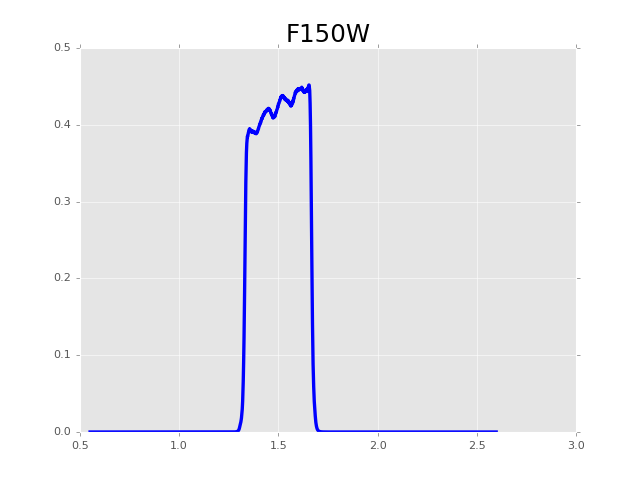

In [63]:
cm_in_pc            = 3.0857e18

Omega_lam           = 0.7274
Omega_M_0           = 0.2726
Omega_k             = 0.0
h                   = 0.704

E   = lambda x: 1/np.sqrt(Omega_M_0*np.power(1+x,3)+Omega_lam+Omega_k*np.power(1+x,2))
D_m = lambda x: D_c(x)
D_c = lambda x: (9.26e27/h)*integrate.quad(E, 0, x)[0]
D_A = lambda x: D_m(x)/(1+x)/cm_in_pc/1e6  # Angular distance [Mpc]

def init_lum_tables():

    global lam_list, lamb

    muf_list = sorted(glob.glob("data/drt/muv.bin*"))
    lam_list = np.zeros(len(muf_list))

    for i in range(len(muf_list)):

        f           = open(muf_list[i])
        header      = f.readline()
        lam_list[i] = float(header.split()[2])

        f.close()

    lamb = lam_list[np.argsort(lam_list)]


def filter_bandwidth(a,b,x):

    global lambdas

    lambdas = []

    for i in range(0,len(x)):
        if (a<=x[i] and x[i]<=b):
            if(F_filter(x[i])>=0.5e-3):
                lambdas.append(x[i])

    return lambdas

def filter_init(name,z):

    global F_filter

    wavelengths,transmission = np.loadtxt('data/filter_F' + name + 'W.dat',skiprows=1).T  
    F_filter = interp1d(wavelengths*10000, transmission,fill_value=0.0,bounds_error=False)
    a,b = np.min(wavelengths*10000),np.max(wavelengths*10000)
    lamb_filter = filter_bandwidth(a,b,lamb*(1+z))

    return lamb_filter

wavelengths,transmission = np.loadtxt('data/filter_F150W.dat',skiprows=1).T 

plt.figure(1)
plt.title('F150W',fontsize=22)
plt.plot(wavelengths,transmission,'b-',lw=3)
plt.show()



In [172]:
calc_input = build_default_calc('jwst', 'nircam', 'sw_imaging')

#The 0th index is taken to be wavelength in units of 'mJy'.
#The 1st index is taken to be the flux in units of 'microns'.
    
calc_input['configuration']['max_scene_size'] = 30
calc_input['configuration']['readmode'] = 'deep8'
calc_input['background'] = 'low'

calc_input['configuration']['instrument']['filter'] = 'f150w'
calc_input['configuration']['detector']['nexp'] = 1

calc_input['strategy']['aperture_size'] = 1.2
calc_input['strategy']['sky_annulus'] = [1.22, 1.4]


calc_input['scene'][0]['spectrum']['normalization']['norm_flux'] = 0e0  # mJy (flat spectrum)
calc_input['scene'][0]['spectrum']['normalization']['norm_wave'] = 1.5   # microns


z 6.20647638469


<IPython.core.display.Javascript object>


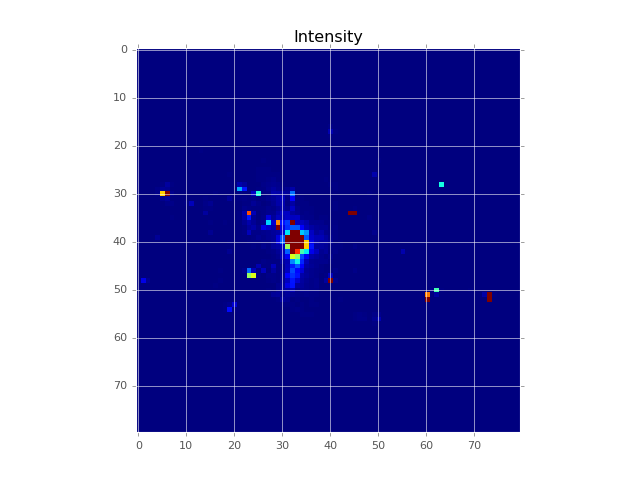

max 9.01441262152e+30
median 0.0
mean 2.32137686421e+27
std 1.20525354273e+29
total 6400
satisfying criteria  12

x:
[73, 32, 33, 32, 33, 34, 32, 33, 34, 32, 29, 6]
y:
[28, 38, 38, 39, 39, 39, 40, 40, 40, 41, 42, 49]



In [186]:
#for i in range(0,len(z)):

i = -1
filter_index = 0
filter_name  = '150'
print('z',z[i])

init_lum_tables()
input_data  = np.load(lums[filter_index,i])
input_data  = input_data[::-1,:,:]
lamb_filter = filter_init(filter_name,z[i])

spec_intensity_sum = np.zeros((nbins_min,nbins_min))

for ii in range(nbins_min):     
        for jj in range(nbins_min):
            spec_intensity_sum[ii,jj] = np.sum(input_data[ii,jj,:])

plt.figure(2)
plt.title('Intensity')
plt.imshow(spec_intensity_sum[::-1,:], interpolation='nearest',vmax=np.max(spec_intensity_sum)/1000)
plt.show()

std = scipy.std(spec_intensity_sum)
mean = scipy.mean(spec_intensity_sum)

print('max',np.max(spec_intensity_sum))
print('median',scipy.median(spec_intensity_sum))
print('mean',mean)
print('std',std)

objects = 0

coords_x = []
coords_y = []

for ii in range(nbins_min):     
        for jj in range(nbins_min):
            if spec_intensity_sum[ii,jj]>=mean*10:
                
                objects += 1
                coords_y.append(ii)
                coords_x.append(jj)
                
print('total', nbins_min*nbins_min)
print('satisfying criteria ',objects)
print()
print('x:')
print(coords_x)
print('y:')
print(coords_y)
print()

In [174]:
def filter_flux(i,l,name):
    
    lum_dist = D_A(z[i]) * (1 + z[i]) * (1 + z[i])
     
    for i in range(0,len(coords_x)):
        
        print(coords_y[i],coords_x[i])  
        flux = 1e26*(1 + z[i])*input_data[coords_y[i],coords_x[i],:]/ (4 * np.pi * np.power(lum_dist*cm_in_pc*1e6,2))
        spec = [np.array(lamb_filter)/1e4,flux]

        source = {
               'id': coords_y[i]+nbins_min*coords_x[i],
               'target': True,
               'position': {
                         'ang_unit': 'arcsec',
                         'x_offset': pixels_angle_coord[coords_x[i]],
                         'y_offset': pixels_angle_coord[coords_y[i]],
                         },
               'shape': {
                         'pa': 0.0,
                         'major': 0.0,
                         'minor': 0.0
                         },
               'spectrum': {
                            'sed': {
                                     "sed_type": "input",
                                     "spectrum":  spec
                                   },
                            'normalization': {
                                               'type': 'none'
                                             },
                            'redshift': 0.0
                            }
              }

        calc_input['scene'].append(source)
            
filter_flux(i,filter_index,filter_name)

    

28 73
38 32
38 33
39 32
39 33
39 34
40 32
40 33
40 34
41 32
42 29
49 6


<IPython.core.display.Javascript object>


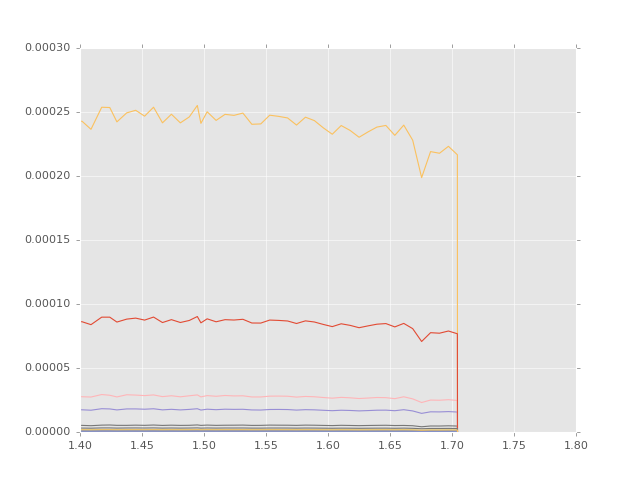

In [175]:
plt.figure(3)
plt.xlim(1.4,1.8)

lum_dist = D_A(z[i]) * (1 + z[i]) * (1 + z[i])
for l in range(len(coords_x)):
    flux =  1e26*(1 + z[i])*input_data[coords_y[l],coords_x[l],:] / (4 * np.pi * np.power(lum_dist*cm_in_pc*1e6,2))
    x = np.append(np.array(lamb_filter),np.max(lamb_filter)+1)
    y = np.append(flux,0.0)
    plt.plot(x/1e4,y)
plt.show()

In [176]:
report = perform_calculation(calc_input, dict_report=False, webapp=True)
report_dict = report.as_dict()
report_fits = report.as_fits()


/home/maryhallow/anaconda3/envs/jwst-workshop/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


{'sn': 14.913628763644882, 'background': 0.17431039010132487, 'background_sky': 714.0232712095353, 'aperture_size': 1.2, 'on_source_time': 1954.68, 'cr_ramp_rate': 0.1551109231922884, 'extracted_noise': 1.376135208091443, 'background_area': 1446.8506791337356, 'reference_wavelength': 1.4931833205573677, 'contamination': 0.001777557370222943, 'y_offset': 0.0, 'extracted_flux': 20.52316962205698, 'extraction_area': 4417.8646691106451, 'x_offset': 0.0, 'filter': 'f150w', 'all_dithers_time': 1954.68, 'background_total': 715.294748661901, 'disperser': None}
(279, 279)


<IPython.core.display.Javascript object>


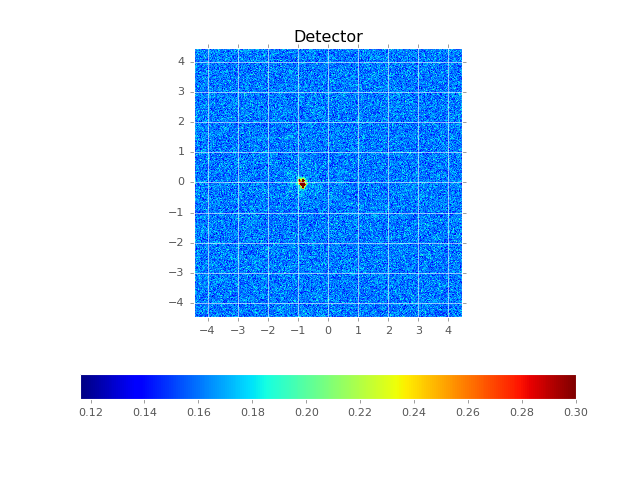

max 2.53525188194
mean 0.161921662565
std 0.0170077481966
max/std 149.064523571


In [182]:
print(report_dict['scalar'])

t = report_dict['transform']
extent = [t['x_min'], t['x_max'], t['y_min'], t['y_max']]

print(np.shape(report_dict['2d']['snr']))

plt.figure(4)
plt.title('Detector')
plt.imshow(report_dict['2d']['detector'], interpolation='nearest', extent=extent,vmax=0.3)
plt.colorbar(orientation='horizontal')
plt.show()

print('max',np.max(report_dict['2d']['detector']))
print('mean',np.mean(report_dict['2d']['detector']))
print('std',np.std(report_dict['2d']['detector']))
print('max/std',np.max(report_dict['2d']['detector'])/np.std(report_dict['2d']['detector']))

In [185]:
#Hubble

'''
118.208
0.624264132091
6.43885163288
18.3585531613
'''


'\n118.208\n0.624264132091\n6.43885163288\n18.3585531613\n'

In [191]:
cm_in_pc = 3.0857e18
speed_of_light      = 2.99792458e10  # [cm/sec]
size = len(input_data[:,1,1])
total_flux = np.zeros((size,size))

nu = speed_of_light/(lamb_filter/(1+z[i])/1e8)
lum_dist = D_A(z[i]) * (1 + z[i]) * (1 + z[i])

print(len(lamb_filter))
print(len(input_data[1,1,:]))
print(len(nu))

for j in range(0,size):
        for k in range(0,size):
            total_flux[j,k] = 1e23 * 1e9 * integrate.trapz( input_data[j,k,::-1] * F_filter(lamb_filter[::-1]), nu[::-1] ) / \
                             integrate.trapz( F_filter(lamb_filter[::-1]*(1+z[i])), nu[::-1] ) * \
                             (1+z[i]) / (4 * np.pi * np.power(lum_dist*cm_in_pc*1e6,2))

59
59
59


/home/maryhallow/anaconda3/envs/jwst-workshop/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


ValueError: operands could not be broadcast together with shapes (58,) (412,) 